# Some cool title

#### Zack Peachell, Jasper Palov, Arjun Saxena, Bhavya Dubey

## Introduction

## Our Methods and Results

Before starting the analysis of the data, several packages need to be loaded in to have most of the functions work in the R language.

In [1]:
#This cell must be run to continue
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 4, repr.plot.height = 4)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

The dataset we are using has to be read in from the Git repository through a relative path, so that we can start manipulating it to reach our conclusion, and to avoid any confusion associated with an absolute path.

In [2]:
star_raw_data <- "https://raw.githubusercontent.com/zackpeachell/DSCI_100_008_05_project/main/6%20class%20csv.csv"
read_star <- read_csv(star_raw_data)
read_star

Rows: 240 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Star color, Spectral Class
dbl (5): Temperature (K), Luminosity(L/Lo), Radius(R/Ro), Absolute magnitude...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3068,0.0024,0.1700,16.12,0,Red,M
3042,0.0005,0.1542,16.60,0,Red,M
2600,0.0003,0.1020,18.70,0,Red,M
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8829,537493,1423,-10.73,5,White,A
9235,404940,1112,-11.23,5,White,A
37882,294903,1783,-7.80,5,Blue,O


Table 1.1

While although this dataset looks tidy, the names of the columns prove to be quite challenging to work with when in R, and therefore will be changed to remove brackets and spaces. As well we will remove any "non-applicable" values for star type, as it is the primary concern for the classification. Also since star type is currently a data value with a decimal, we will change it to a factor for classification. 

In [3]:
set.seed(9999)
name_star <- read_star|>
                rename("Star_type" = "Star type")|>
                rename("Temperature_K" = "Temperature (K)")|>
                rename("Star_color" = "Star color")|>
                rename("Spectral_Class" = "Spectral Class")|>
                rename("Luminosity_ratio" = "Luminosity(L/Lo)")|>
                rename("Radius_ratio" = "Radius(R/Ro)")|>
                rename("Absolute_magnitude_Mv" = "Absolute magnitude(Mv)")|>
                filter(Star_type != "NA")|>
                mutate(Star_type = as_factor(Star_type))
name_star

Temperature_K,Luminosity_ratio,Radius_ratio,Absolute_magnitude_Mv,Star_type,Star_color,Spectral_Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
3068,0.0024,0.1700,16.12,0,Red,M
3042,0.0005,0.1542,16.60,0,Red,M
2600,0.0003,0.1020,18.70,0,Red,M
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8829,537493,1423,-10.73,5,White,A
9235,404940,1112,-11.23,5,White,A
37882,294903,1783,-7.80,5,Blue,O


Table 2.1

One final item of tidying we can do is to select/remove columns we do not want, such as the Spectral class, Luminosity ratio and Star color columns as they will have little effect on our classifier, and can be removed for clarity purposes. 

In [4]:
set.seed(9999)
select_star <- name_star|>
                select(-Spectral_Class, -Luminosity_ratio, -Star_color)
select_star

Temperature_K,Radius_ratio,Absolute_magnitude_Mv,Star_type
<dbl>,<dbl>,<dbl>,<fct>
3068,0.1700,16.12,0
3042,0.1542,16.60,0
2600,0.1020,18.70,0
⋮,⋮,⋮,⋮
8829,1423,-10.73,5
9235,1112,-11.23,5
37882,1783,-7.80,5


Table 3.1

This data is very tidy, table 3.1, and we could transition to the classification model, but first values for maximums, minimums and means of the individual predictors could prove to be very useful to show trends of the predictors for each star type. As well summarizing the total amount of each star type could equally prove useful to ensure there isn't a great variation in each star type.

In [5]:
set.seed(9999)
star_type_count <- select_star|>
                    group_by(Star_type)|>
                    summarize(count = n())

star_type_count
star_type_mean <- select_star |>
                    group_by(Star_type)|>
                    summarize(Temp_mean = mean(Temperature_K, na.rm = TRUE), Radius_ratio_mean = mean(Radius_ratio, na.rm = TRUE), Absolute_mean = mean(Absolute_magnitude_Mv, na.rm = TRUE))
star_type_max <- select_star |>
                    group_by(Star_type)|>
                    summarize(Temp_max = max(Temperature_K, na.rm = TRUE), Radius_ratio_max = max(Radius_ratio, na.rm = TRUE), Absolute_mean = max(Absolute_magnitude_Mv, na.rm = TRUE))
star_type_min <- select_star |>
                    group_by(Star_type)|>
                    summarize(Temp_min = min(Temperature_K, na.rm = TRUE), Radius_ratio_min = min(Radius_ratio, na.rm = TRUE), Absolute_min = min(Absolute_magnitude_Mv, na.rm = TRUE))
star_type_mean
star_type_max
star_type_min

Star_type,count
<fct>,<int>
0,40
1,40
2,40
3,40
4,40
5,40


Star_type,Temp_mean,Radius_ratio_mean,Absolute_mean
<fct>,<dbl>,<dbl>,<dbl>
0,2997.950,1.100150e-01,17.563500
1,3283.825,3.481450e-01,12.539975
2,13931.450,1.072825e-02,12.582500
3,16018.000,4.430300e+00,-0.367425
4,15347.850,5.115000e+01,-6.369925
5,11405.700,1.366898e+03,-9.654250


Star_type,Temp_max,Radius_ratio_max,Absolute_mean
<fct>,<dbl>,<dbl>,<dbl>
0,3531,0.190,20.060
1,3692,0.730,14.940
2,25000,0.015,14.870
3,39000,10.600,6.506
4,40000,98.000,-5.240
5,38940,1948.500,-7.580


Star_type,Temp_min,Radius_ratio_min,Absolute_min
<fct>,<dbl>,<dbl>,<dbl>
0,1939,0.0570,16.05
1,2621,0.0980,10.12
2,7100,0.0084,10.18
3,4077,0.7950,-4.70
4,3008,12.0000,-7.45
5,3399,708.9000,-11.92


In order of appearance, Table 4.1, Table 4.2, Table 4.3, Table 4.4

These tibbles show that there is a defintley a relationship between mean averages, maximums and minimums and each variable and the respective Star type. An attempt at visualization to define this relationship is needed and each predictor that we will be using should be plotted against one another, colored with the Star type to show the appropraite relationship.

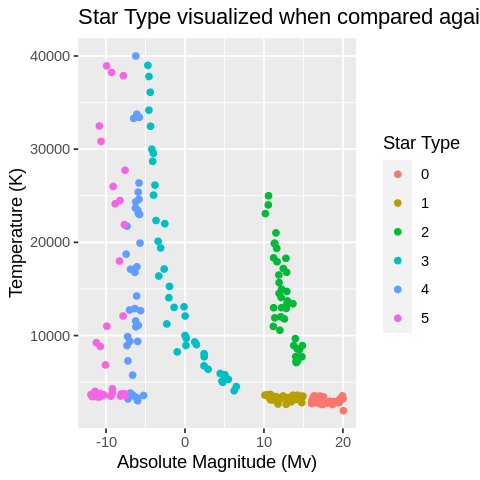

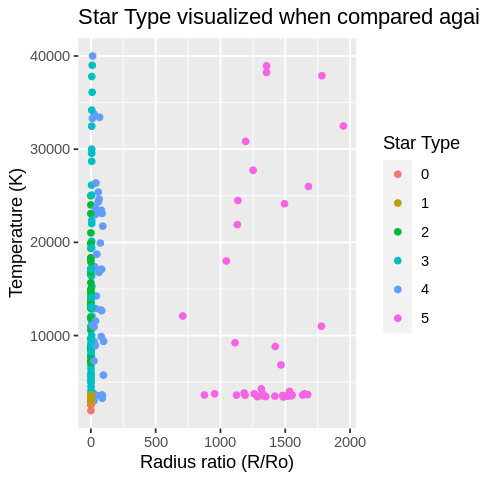

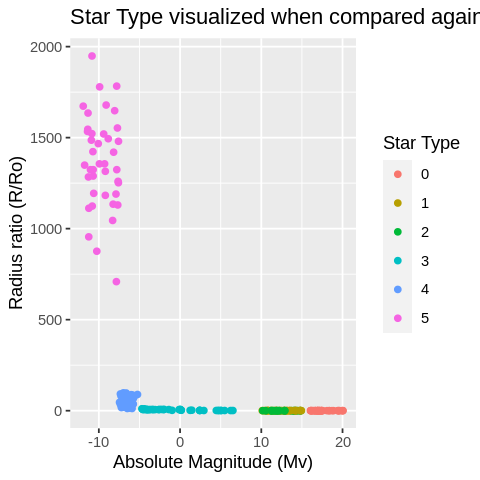

In [6]:
set.seed(9999)
star_plot_1 <- select_star|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")
star_plot_2 <- select_star|>
                    ggplot(aes(x = Radius_ratio, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Radius ratio (R/Ro)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and the Radius ratio")+
                    scale_fill_brewer(palette = "Set2")
star_plot_3 <- select_star|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Radius_ratio))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Radius ratio (R/Ro)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Radius ratio and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")
star_plot_1
star_plot_2
star_plot_3

In order of appearance; Fig.1.1, Fig.1.2, Fig.1.3

This shows very clear trends/patterns between the predictors and Star type, these relationships important for predicting. We can now create the classification model. A split in the data to create a training and testing dataset to be used to test the accuracy and tune for the best value for the K nearest neighbors.

In [7]:
set.seed(9999)
split_star <- initial_split(select_star, prop = 0.75, strata = Star_type)
train_star <- training(split_star)
test_star <- testing(split_star)
train_star

Temperature_K,Radius_ratio,Absolute_magnitude_Mv,Star_type
<dbl>,<dbl>,<dbl>,<fct>
3068,0.1700,16.12,0
3042,0.1542,16.60,0
2600,0.1020,18.70,0
⋮,⋮,⋮,⋮
30839,1194,-10.63,5
8829,1423,-10.73,5
37882,1783,-7.80,5


Table 5.1

This data must be scaled or it will not be of any use to us, as some values are extremely large, and will have more contribution to the distance formula than some other variables(e.g. Temperature is in the thousands, reaching a max at some star types of 35,000-40,000 K, while absolute magnitude doesn't have values greater than 20). We can then bake our recipe to see if the scaling for the values occured.

In [8]:
set.seed(9999)

star_recipe <- recipe(Star_type ~ Temperature_K + Radius_ratio + Absolute_magnitude_Mv, data = train_star)|>
                    step_scale(all_predictors())|>
                    step_center(all_predictors())|>
                    prep()
star_scale <- bake(star_recipe, name_star)

star_scale

Temperature_K,Radius_ratio,Absolute_magnitude_Mv,Star_type
<dbl>,<dbl>,<dbl>,<fct>
-0.7696518,-0.4579647,1.106692,0
-0.7724949,-0.4579954,1.152133,0
-0.8208272,-0.4580968,1.350938,0
⋮,⋮,⋮,⋮
-0.13969116,2.306704,-1.435171,5
-0.09529539,1.702407,-1.482506,5
3.03723077,3.006212,-1.157791,5


Table 6.1

A reasonable value for K must be determined, which will yield the greatest accuracy for when we test against the testing data, where tuning and cross-validation can be performed on the testing data to determine a good K value. Some assumptions include that a 5 fold cross-validation will be performed and that k values from 2 to 10 will be tested only. There will be little effect present on the overall accuracy of the model. The metrics of this workflow we create will be analyzed to determine the best k value.

In [15]:
set.seed(9999)

kknn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
                    set_engine("kknn")|>
                    set_mode("classification")

star_vfold <- vfold_cv(train_star, v = 5, strata = Star_type)

k_vals <- tibble(neighbors = seq(from = 2, to = 10, by = 1))

star_workflow <- workflow()|>
                    add_recipe(star_recipe)|>
                    add_model(kknn_tune)|>
                    tune_grid(resamples = star_vfold, grid = k_vals)|>
                    collect_metrics()
star_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.9944444,5,0.005555556,Preprocessor1_Model1
2,roc_auc,hand_till,0.9985185,5,0.001079806,Preprocessor1_Model1
3,accuracy,multiclass,0.9722222,5,0.008784105,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.9971296,5,0.001137797,Preprocessor1_Model8
10,accuracy,multiclass,0.9611111,5,0.014163943,Preprocessor1_Model9
10,roc_auc,hand_till,0.9962963,5,0.001085744,Preprocessor1_Model9


Table 7.1

Now that we have done this workflow, we should extract the neighbors and there relative accuracy, hidden in the "mean" column, to determine which K gives the greatest accuracy for our classification model. We can also visualize this as a graph of neighbors vs accuracy, using a line graph, to determine which K value returns the greatest accuracy from the vfold splitting.

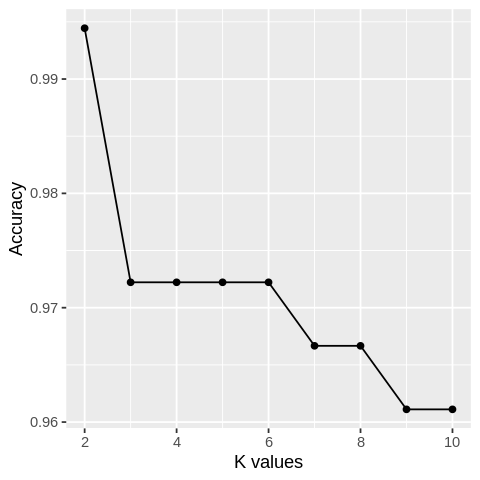

In [17]:
set.seed(9999)

accuracies <- star_workflow |>
                filter(.metric == "accuracy")
options(repr.plot.height = 4, repr.plot.width = 4)
best_k_plot <- accuracies |>
                ggplot(aes(x = neighbors, y = mean))+
                geom_point()+
                geom_line()+
                xlab("K values")+
                ylab("Accuracy")
best_k_plot

Fig.2.1

This graph best desrcibes that accuracy is really high when using k = 2 as it is almost a hundred percent accurate. Using this k value, the workflow should be redesigned using this k value so we can test the accuracy against new data, the test data. The same star recipe will be used from before as nothing changes and we need that recipe in order to test the testing data.

In [18]:
set.seed(9999)

best_k <- 2

best_kknn <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k)|>
                set_engine("kknn")|>
                set_mode("classification")

best_fit <- workflow()|>
                add_recipe(star_recipe)|>
                add_model(best_kknn)|>
                fit(data = train_star)

best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02222222
Best kernel: rectangular
Best k: 2

We have now created the most accuarate workflow using the best k value, we can predict and test the accuracy against the testing data, using the predict and metric functions to achieve this goal. Then the result can be filtered to give a column of the accuracy of the model.

In [12]:
set.seed(9999)
star_predictions <- predict(best_fit, test_star)|>
                        bind_cols(test_star)

star_accuracies <- star_predictions|>
                     metrics(truth = Star_type, estimate = .pred_class)|>
                      filter(.metric == "accuracy")  

star_accuracies

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9833333


Table 8.1

This proves that our classifier is very accurate, near 100 percent. We should move to test a point that we know the class for but isn't part of this dataset, to see if it holds up with the classification model. It is predicted that the classifier will accuratley identify the star type for this point. 

In [13]:
set.seed(9999)
new_obs_1 <- tibble(Temperature_K = 5800, Radius_ratio = 0.0127811127, Absolute_magnitude_Mv = 15.429, Star_type = NA)

kknn_predict_1 <- predict(best_fit, new_obs_1)
kknn_predict_1

.pred_class
<fct>
2


Table 9.1

This classifier predicts that our star type will be 2, table 8.1, which according to the dataset, means that this star will be a white dwarf, and therefore proves that the classifier can predict correctly from outside the dataset. Using the knowledge that this has an accuracy of 98%, we expect that the dataset can classify points from outside. A visulaization of our new point on the pre-existing dataset should be made to illustrate the classification model at work. Note that the white dwarf star is classification of star type 2.

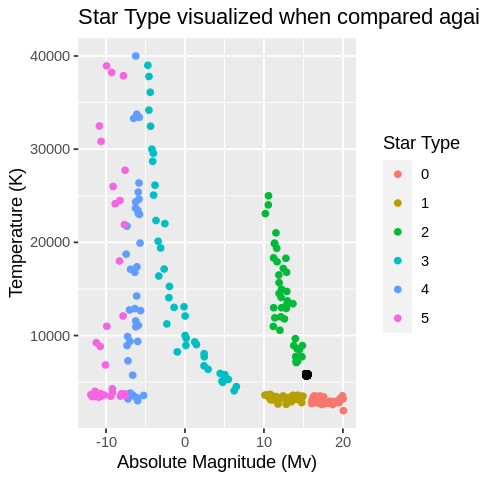

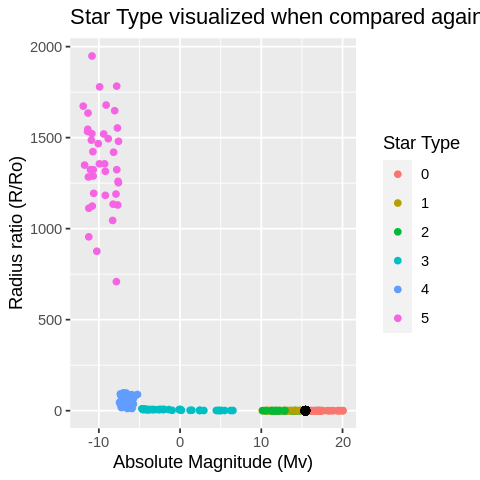

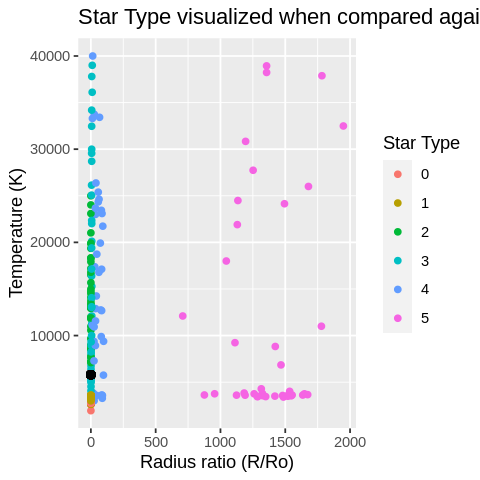

In [14]:
set.seed(9999)
star_plot_obs_1 <- name_star|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")

star_plot_obs_2 <- name_star|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Radius_ratio))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Radius ratio (R/Ro)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Radius ratio and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")

star_plot_obs_3 <- name_star|>
                    ggplot(aes(x = Radius_ratio, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Radius ratio (R/Ro)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")

star_plot_obs_1 <- star_plot_obs_1+
                            geom_point(aes(x = 15.429, y = 5800), colour = "black", size = 2)
star_plot_obs_2 <- star_plot_obs_2+
                            geom_point(aes(x = 15.429, y = 0.0127811127), colour = "black", size = 2)
star_plot_obs_3 <- star_plot_obs_3+
                            geom_point(aes(x = 0.0127811127, y = 5800), colour = "black", size = 2)

star_plot_obs_1
star_plot_obs_2
star_plot_obs_3

In order of appearance; Fig.3.1, Fig.3.2, Fig.3.3

Fig.3.2 and Fig.3.3 show very little in terms of their graphs, as all the points are grouped together making it hard to distinguish, however some of the class 2 points are part of that grouping. Remember this data isn't scaled yet so that could be a contributing factor to their unique shapes. Fig.3.1 however shows the new point as being close to the other class 2 points, affirming that the visualization shows that the classifier is correct!

## Discussion of Results

## References

Deepraj Baidya. 2019. Star dataset to predict star types. Retrieved October 24th 2023 from https://www.kaggle.com/datasets/deepu1109/star-dataset/data.
\
\
“Types of Stars: Stellar Classification, Lifecycle, and Charts.” AstroBackyard, 7 Nov. 2023, https://astrobackyard.com/types-of-stars/. 
\
\
Loeb, Avi. “Living near a White Dwarf.” Scientific American, 13 Nov. 2020, www.scientificamerican.com/article/living-near-a-white-dwarf/.